In [28]:
import pandas as pd
import wordninja
import nltk
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize, ne_chunk
from sentence_transformers import SentenceTransformer, util
from keybert import KeyBERT
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import openTSNE
import umap.umap_ as umap
import hdbscan
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA
import plotly.express as px

In [4]:
df = pd.read_csv('cleaned_data_name_thread.csv')

In [10]:
df.dropna(subset=['name_thread'], inplace=True)
df.drop_duplicates(subset=['name_thread'], inplace=True)
df['name_thread'] = df['name_thread'].apply(lambda x: ' '.join(wordninja.split(x)))

In [12]:
df['name_thread'].to_csv('name_thread_wordninja.txt', index=False, header=False)

In [15]:
def reduce_dimensionality_Opentsne(corpus_embeddings, n_components=2, perplexity=30, n_iter=1000):
    """
    Reduce dimensionality of embeddings with t-SNE using openTSNE.
    :param n_components: the number of components to reduce to
    :param perplexity: the perplexity value
    :param n_iter: the number of iterations
    :return: the reduced embeddings
    """
    corpus_embeddings = np.array(corpus_embeddings.tolist())
    tsne = openTSNE.TSNE(
        n_components=n_components,
        perplexity=perplexity,
        n_iter=n_iter,
        metric="cosine",
        initialization="pca",
        negative_gradient_method="fft",
        n_jobs=-1
    )
    reduced_embeddings = tsne.fit(corpus_embeddings)
    return np.array(reduced_embeddings, dtype=np.float32)

def plot_clusters(embeddings_2d, cluster_labels):
    """
    Visualize clusters in 2D as dots.
    :param embeddings_2d: the 2D embeddings
    :param cluster_labels: the labels of the clusters
    """
    plt.figure(figsize=(10, 8))
    unique_labels = set(cluster_labels)
    # Generate a different color for each cluster
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
        else:
            marker = 'o'
        class_member_mask = (cluster_labels == k)
        xy = embeddings_2d[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=col, markeredgecolor='k', markersize=6, alpha=0.6, label=f'Cluster {k}')
    plt.title('2D Cluster Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

In [6]:
df1 = pd.read_parquet('Results_BERTopic/BERTopic_10_topics_15n_5com_800clu_300_mintopic_0dist_1sample.parquet')
df1.head()

Document  \
0                            tor shrinked contribute   
1                                       run tor node   
2                                        tor browser   
3               updated tor security guide crosspost   
4  costcorotisseriechicken spreading fud let smas...   

                                           Embedding  Topic  Probability  \
0  [0.0003665863, -0.10446195, 0.0029864428, 0.05...      3     0.494936   
1  [0.01806473, -0.04132147, 0.028041542, 0.03931...     -1     0.000000   
2  [0.07406256, -0.038671, -0.0035331931, 0.02606...     -1     0.000000   
3  [-0.057483885, 0.026145194, 0.012629288, 0.042...     -1     0.000000   
4  [0.014889583, -0.06421399, 0.030089099, -0.008...     -1     0.000000   

   Count                           Name  \
0   4482            3_back_day_mdma_lsd   
1  15980  -1_ticket_update_help_support   
2  15980  -1_ticket_update_help_support   
3  15980  -1_ticket_update_help_support   
4  15980  -1_ticket_update_help_support   

                                      Representation  \
0  [back, day, mdma, lsd, get, still, welcome, th...   
1  [ticket, update, help, support, please, dread,...   
2  [ticket, update, help, support, please, dread,...   
3  [ticket, update, help, support, please, dread,...   
4  [ticket, update, help, support, please, dread,...   

                                 Representative_Docs  
0                 [wsm back, back day, welcome back]  
1  [dispute support ticket, admins please help su...  
2  [dispute support ticket, admins please help su...  
3  [dispute support ticket, admins please help su...  
4  [dispute support ticket, admins please help su...

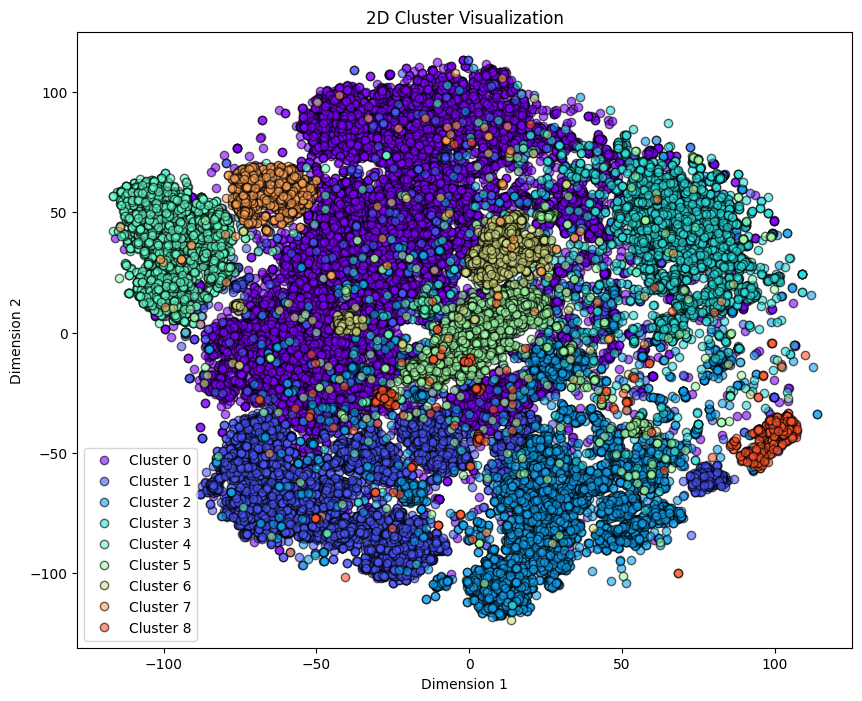

In [22]:
red_embeddings = reduce_dimensionality_Opentsne(df1['Embedding'], perplexity=70, n_iter=1000)
plot_clusters(red_embeddings, df1['Topic'])

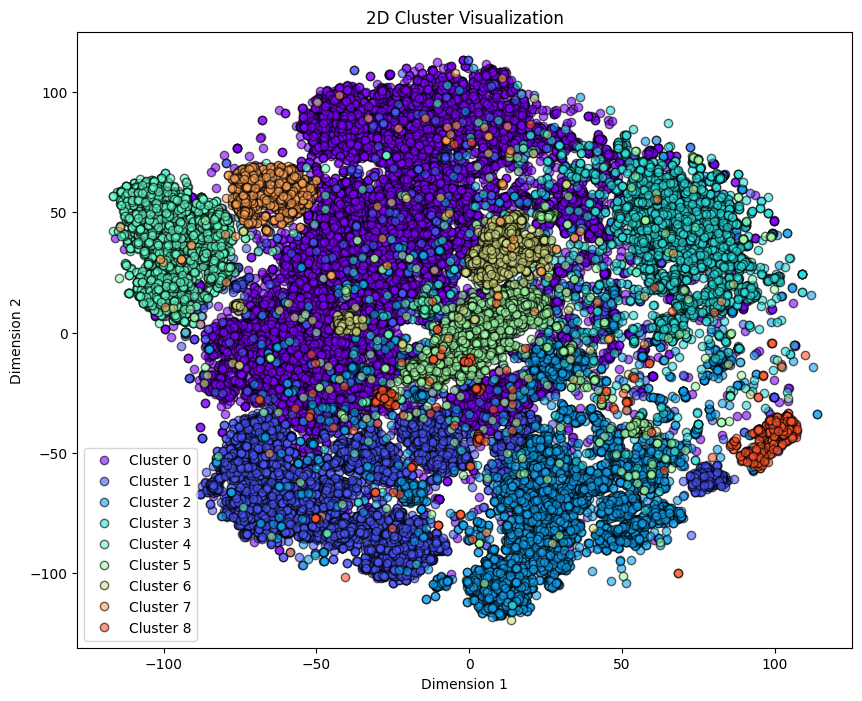

In [24]:
plot_clusters(red_embeddings, df1['Topic'])

In [37]:
def plot_only5_clusters(embeddings_2d, cluster_labels, n_clusters=4):
    """
    Visualize clusters in 2D as dots.
    :param embeddings_2d: the 2D embeddings
    :param cluster_labels: the labels of the clusters
    """
    plt.figure(figsize=(10, 8))
    unique_labels = set(cluster_labels)
    # Filter to include only clusters from 0 to 5
    unique_labels = {label for label in unique_labels if label <= n_clusters}
    # Generate a different color for each cluster
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue  # Skip outliers
        marker = 'o'
        class_member_mask = (cluster_labels == k)
        xy = embeddings_2d[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=col, markeredgecolor='k', markersize=6, alpha=0.6, label=f'Cluster {k}')
    
    plt.title('2D Cluster Visualization (Clusters 0 to 5)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

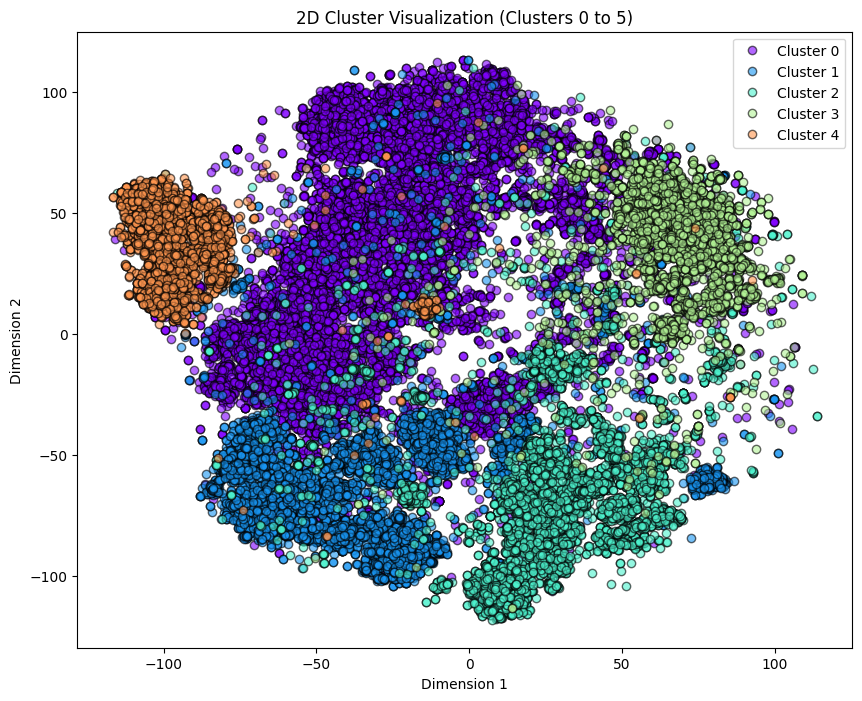

In [25]:
plot_only5_clusters(red_embeddings, df1['Topic'])

In [33]:
red_embeddings2 = reduce_dimensionality_Opentsne(df1['Embedding'], perplexity=90, n_iter=1000)

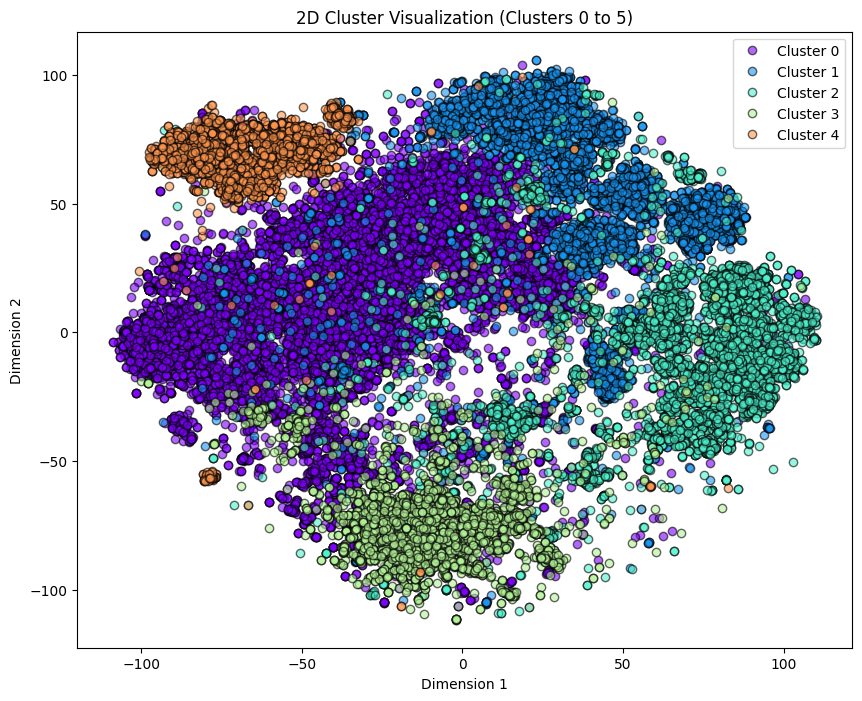

In [42]:
plot_only5_clusters(red_embeddings2, df1['Topic'], n_clusters=4)

In [43]:
red_embeddings3 = reduce_dimensionality_Opentsne(df1['Embedding'], perplexity=60, n_iter=1000)

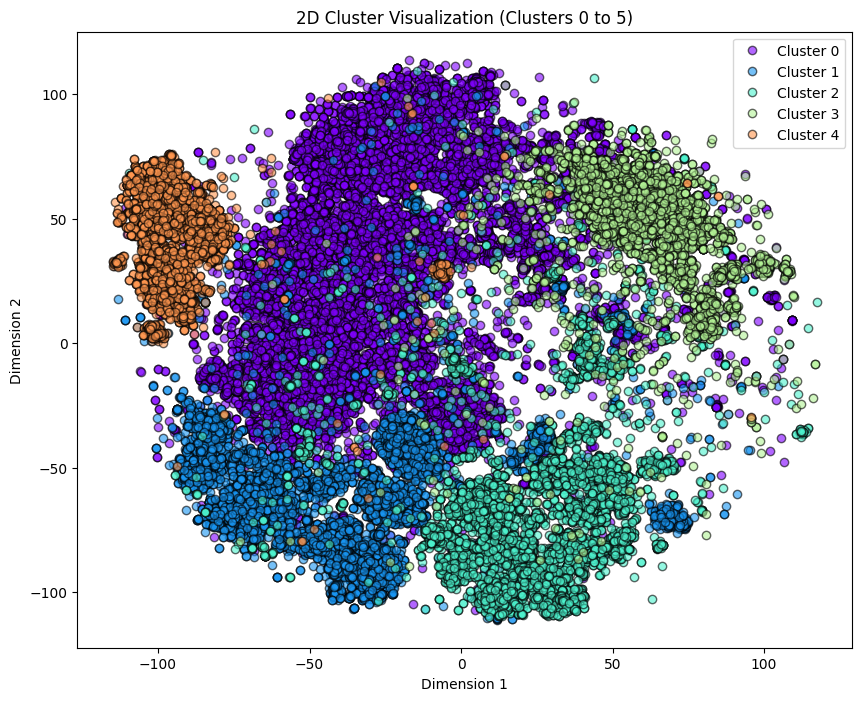

In [46]:
plot_only5_clusters(red_embeddings3, df1['Topic'], n_clusters=4)